GRP into python
  * Read Data (Complete list: Commodity)
  * Calculate Signal for each strategy (Complete list: CVA)
    * TS
    * CS
  * Backtesting ( 'Factor' in GRP )
    * TS
    * CS
  

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

# Read Data

In [3]:
# Comdty data
cindex = pd.read_csv('./data/fut1return-com.csv', header=0, index_col=0, parse_dates=True)
cindex2 = pd.read_csv('./data/BCOM.csv', header=0, index_col=0, parse_dates=True)

CRet = cindex.pct_change(1).iloc[1:]
CRet2 = cindex2.pct_change(1).iloc[1:]
Cindex = (1. + CRet).cumprod()

# Calculate Signal

# CCA3
** Commodity CArry 전략 **

2가지 Carry 전략을 합한 전략. carry-com.csv 와 carry-com2.csv 두 개를 사용하는데 무슨 차이인지 지금은 모름. carry_com은 과거 5년 랭킹을 기준으로 롱숏을 하고 carry_com2는 TS의 경우 0보다 크면 롱, 작으면 숏. CS는 랭킹. 

Notes. 이 전략의 경우 날씨에 민감한 상품을 따로 Cross Sectional한 전략이 더 좋다.

In [5]:
# CCA3 - TS: Monthly, CS:
# Param Settings
RET = CRet
index = Cindex

w_group = ["C","S","SB","SM","W","KC","CT"] # weather sensitive comdty group
n_w_group = [x for x in Cindex.columns if x not in w_group]
c_groups = [w_group, n_w_group]

div_group_flag = True # divide groups for cross sectional strategy

nopos = 0.4 # no position zone in the middle of two extreme
CS = 0.35 # Percent of positions for Cross Sectional Signal
RB = 1 # rebalancing weekday

minobs = 60

# Making Signals
carry1 = pd.read_csv('./data/carry-com.csv', header=0, index_col=0, parse_dates=True)
carry2 = pd.read_csv('./data/carry-com2.csv', header=0, index_col=0, parse_dates=True)

RV1 = carry1 + carry1.shift(1)
RV2 = carry2 + carry2.shift(1)

pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]
RVrank1 = RV1.rolling(minobs).apply(pctrank) # it takes some time
#RVrank2 = RV2.rolling(minobs).apply(pctrank) # it takes some time

# Time Series Signal
TSRV1 = RVrank1 * 0.
TSRV1[RVrank1 > (nopos + (1.-nopos)/2.)] = 1.
TSRV1[RVrank1 < ((1.-nopos)/2.)] = -1.

TSRV2 = RV2 * 0.
TSRV2[RV2 > 0.] = 1.
TSRV2[RV2 < 0.] = -1.

TSRV = TSRV1 * 0.5 + TSRV2

# Cross SEctional Signal
if div_group_flag:
    CSRV = pd.DataFrame()
    for c_group in c_groups:
        truecount_lower = (RV1[c_group].notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
        truecount_upper = RV1[c_group].notnull().sum(axis=1) - truecount_lower

        CSRV1 = RV1[c_group].rank(axis=1)
        CSRV1[CSRV1.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
        CSRV1[CSRV1.apply(lambda x: x > truecount_upper, axis=0)] = 1.

        CSRV1 = CSRV1.applymap(lambda x: x if x == 1. or x == -1. else 0.)

        truecount_lower = (RV2[c_group].notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
        truecount_upper = RV2[c_group].notnull().sum(axis=1) - truecount_lower

        CSRV2 = RV2[c_group].rank(axis=1)
        CSRV2[CSRV2.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
        CSRV2[CSRV2.apply(lambda x: x > truecount_upper, axis=0)] = 1.

        CSRV2 = CSRV2.applymap(lambda x: x if x == 1. or x == -1. else 0.)
        
        CSRV = pd.concat([CSRV, (CSRV1 * 0.5 + CSRV2)], axis=1)
        
else:
    truecount_lower = (RV1.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
    truecount_upper = RV1.notnull().sum(axis=1) - truecount_lower

    CSRV1 = RV1.rank(axis=1)
    CSRV1[CSRV1.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
    CSRV1[CSRV1.apply(lambda x: x > truecount_upper, axis=0)] = 1.

    CSRV1 = CSRV1.applymap(lambda x: x if x == 1. or x == -1. else 0.)

    truecount_lower = (RV2.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
    truecount_upper = RV2.notnull().sum(axis=1) - truecount_lower

    CSRV2 = RV2.rank(axis=1)
    CSRV2[CSRV2.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
    CSRV2[CSRV2.apply(lambda x: x > truecount_upper, axis=0)] = 1.

    CSRV2 = CSRV2.applymap(lambda x: x if x == 1. or x == -1. else 0.)
    
    CSRV = CSRV1 * 0.5 + CSRV2


# Align dates with Return DataFrame
TSRV = TSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')
CSRV = CSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')

# Align dates with each other
if TSRV.index[0] > CSRV.index[0]:
    CSRV = CSRV.loc[TSRV.index[0]:]
else:
    TSRV = TSRV.loc[CSRV.index[0]:]
    
min_vol = 0.15
freq = 'month'

C:\Users\Mirae\Anaconda3\envs\cpu_tensor\lib\site-packages\ipykernel_launcher.py:87: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\Mirae\Anaconda3\envs\cpu_tensor\lib\site-packages\ipykernel_launcher.py:88: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


## CVA

** Commodity Value 전략 **

과거 63일 동안 상승했을 경우 변동성, 하락했을 경우 변동성을 각각 계산해서 하락 변동성 - 상승 변동성이 가장 큰 경우 Long, 낮은 경우 Short. 하락 변동성이 컸다는 건 많이 빠졌다는 의미로 많이 빠진 것을 사고 많이 오른 것을 파는 것이기 때문에 Value.

Notes. 대표님의 요구로 날씨 민감 그룹과 날씨 민감하지 않은 그룹을 나눠서 실제 했었음. -> 나누지 않는 것이 더 나았음.

In [6]:
# CVA - weekly
# Param Settings
RET = CRet
index = Cindex

w_group = ["C","S","SB","SM","W","KC","CT"] # weather sensitive comdty group
n_w_group = [x for x in Cindex.columns if x not in w_group]
c_groups = [w_group, n_w_group]

per = 63 # lookback period for calculating stdev
nopos = 0.6 # no position zone in the middle of two extreme
CS = 0.35 # Percent of positions for Cross Sectional Signal
RB = 1 # rebalancing weekday

# Making Signal
Retpos = RET[RET>0]
Retneg = RET[RET<0]

STDpos = Retpos.rolling(window=per, min_periods=1).std().fillna(0).iloc[per-1:]
STDneg = Retneg.rolling(window=per, min_periods=1).std().fillna(0).iloc[per-1:]

RV = STDneg - STDpos
RV = RV[RV.index.weekday == RB] # to weekly

# Time Series Signal
pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]
RVrank = RV.expanding().apply(pctrank) # it takes some time

TSRV = RVrank * 0.
TSRV[RVrank > (nopos + (1.-nopos)/2.)] = 1.
TSRV[RVrank < ((1.-nopos)/2.)] = -1.

# Cross Sectional Signal
truecount_lower = (RV.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
truecount_upper = RV.notnull().sum(axis=1) - truecount_lower

CSRV = RV.rank(axis=1)
CSRV[CSRV.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
CSRV[CSRV.apply(lambda x: x > truecount_upper, axis=0)] = 1.

CSRV = CSRV.applymap(lambda x: x if x == 1. or x == -1. else 0.)

# Align dates with Return DataFrame
TSRV = TSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')
CSRV = CSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')

# Align dates with each other
if TSRV.index[0] > CSRV.index[0]:
    CSRV = CSRV.loc[TSRV.index[0]:]
else:
    TSRV = TSRV.loc[CSRV.index[0]:]
    
min_vol = 0.15
freq = 'week'

C:\Users\Mirae\Anaconda3\envs\cpu_tensor\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\Mirae\Anaconda3\envs\cpu_tensor\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


# Backtesting

In [1]:
def ex_ante_vol(df_ret, todate, weights, lookback=130, shrink_corr=0.9):
    '''
    Args:
        df_ret: pandas DataFrame of returns
        todate: date to calculate ex ante vol
        weights: weight of strategy before ex ante vol control
        lookback: number of days to consider for calculating cov
        shrink_corr: weight to shrink correlation
    '''
    # setting data range
    todate_loc = df_ret.index.get_loc(todate)
    if todate_loc > lookback:
        fromdate_loc = todate_loc - lookback
    else:
        fromdate_loc = 0
    
    # calculate corr apply shrinkage
    corr = df_ret.iloc[fromdate_loc:todate_loc].corr()
    corr = corr * shrink_corr + np.diag(np.ones(len(df_ret.columns))) * (1.- shrink_corr)
    # calculate cov
    std = df_ret.iloc[fromdate_loc:todate_loc].std()
    cov = pd.DataFrame(np.diag(std).dot(corr).dot(np.diag(std)), index=RET.columns, columns=RET.columns)
    # calculate ex ante vol
    print(cov)
    return np.sqrt(weights.dot(cov).dot(weights)) * np.sqrt(260)

In [2]:
class GRP_bt:
    '''
    '''
    def __init__(self, CSLS, RET, RB, min_vol, freq):
        '''
        '''
        self.CSLS = CSLS  # Cross Sectional Exposure Type. 'vol' means volatility allocation. 'notional' means notional. 
        self.RET = RET  # 
        self.RB = RB
        
        self.Assetvol = 0.02 # vol control parameter for individual assets
        self.Strategyvol = 0.02 # vol control parameter for whole strategy
        self.factorvol = 0.02
        self.factorsd = 260 # lookback period for calcualting factorvol
        self.assetsd = 90 # lookback period for calculating Assetvol
        self.statsd = 90 # lookback period for calcualting Strategyvol

        self.volband = 0.05 # if controled vol is within volband, do not change vol
        self.min_vol = min_vol # vol floor 0.04 for ir strategy, 0.15 for all otheres
        self.freq = freq # strategy frequency setting. it only applys to Cross Sectional backtesting now.
        
        # Calculating volatility for assets
        std = (self.RET.rolling(window=self.assetsd).std() * np.sqrt(260)).iloc[self.assetsd:]
        # Adjust calculated asset volatility
        self.std_adj = self.adjust_by_volband(std, self.volband, min_vol=self.min_vol)

    def adjust_by_volband(self, df_vol, volband, min_vol=None):
        for i in range(1, len(df_vol.index)):
            if df_vol.iloc[i].name.weekday() == self.RB:
                for c in range(len(df_vol.columns)):
                    # case1. if new std is null
                    if pd.isnull(df_vol.iloc[i, c]):
                        df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
                    # case2. if new std within volband
                    if abs(df_vol.iloc[i, c] - df_vol.iloc[i-1, c]) < volband * df_vol.iloc[i-1, c] :
                        df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
            else:
                df_vol.iloc[i] = df_vol.iloc[i-1]
        if min_vol is not None:
            df_vol[df_vol < min_vol] = min_vol

        return df_vol
    
    def ts_vol_control_backtest(self, TSRV):
        # Time Series 
        VCweight = self.Assetvol / self.std_adj
        VCTSpos = (VCweight * TSRV).loc[TSRV.index[0]:] # Vol Control Time Series Position
        VCTSpos.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Strategy level vol control
        # return of VC strategy
        Strategy = ((self.RET * VCTSpos.shift(1)).sum(axis=1)).loc[TSRV.index[0]:]
        # using average of expanding & moving window strategy risk
        Strategyrisk_expanding = (Strategy.expanding(min_periods=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        Strategyrisk_rolling = (Strategy.rolling(window=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        Strategyrisk = (Strategyrisk_expanding + Strategyrisk_rolling) / 2.
        # volband adjustment
        bufrisk = self.adjust_by_volband(Strategyrisk.copy().to_frame(), self.volband)
        # apply strategy level vol control to position
        statlev = self.Strategyvol / bufrisk.iloc[:,0]
        self.TSposition = VCTSpos.multiply(statlev, axis='index').iloc[self.statsd:]
        self.TSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.TSposition.fillna(0, inplace=True)
        
        # calculate daily strategy return
        self.TSStrategy = (self.RET * self.TSposition.shift(1)).sum(axis=1).loc[TSRV.index[0]:]
        self.TSStrategylag = (self.RET * self.TSposition.shift(2)).sum(axis=1).loc[TSRV.index[0]:]
    
    def cs_vol_control_backtest(self, CSRV):
        if self.CSLS == 'vol':
            CSRV = (CSRV * self.Assetvol / self.std_adj).loc[CSRV.index[0]:]
        #elif self.CSLS != 'notional': # raise error
            
        # Calculating Ex-ante Vol and adjust to target vol which specified by 'Strategyvol'
        if self.freq == 'week':
            for i in range(len(CSRV.index)):
                if CSRV.iloc[i].name.weekday() == self.RB:
                    CSRV.iloc[i] = CSRV.iloc[i] * self.Strategyvol / ex_ante_vol(self.RET, CSRV.iloc[i].name, CSRV.iloc[i])
                else:
                    CSRV.iloc[i] = CSRV.iloc[i-1]
        elif self.freq == 'month':
            for i in range(len(CSRV.index)):
                if CSRV.iloc[i].name.month != CSRV.iloc[i-1].name.month:
                    CSRV.iloc[i] = CSRV.iloc[i] * self.Strategyvol / ex_ante_vol(self.RET, CSRV.iloc[i].name, CSRV.iloc[i])
                else:
                    CSRV.iloc[i] = CSRV.iloc[i-1]
        #else: # raise error
            
        # Strategy level vol control
        # return of VC strategy
        CSraw = (self.RET * CSRV.shift(1)).dropna(how='all').sum(axis=1)
        CSrisk = (CSraw.rolling(window=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        
        # volband adjustment
        cs_bufrisk = self.adjust_by_volband(CSrisk.to_frame(), self.volband)
        # apply strategy level vol control to position
        cs_statlev = self.Strategyvol / cs_bufrisk.iloc[:,0]
        self.CSposition = CSRV.multiply(cs_statlev, axis='index').iloc[self.statsd:]
        self.CSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.CSposition.fillna(0, inplace=True)
        
        # calculate daily strategy return
        self.CSStrategy = (self.RET * self.CSposition.shift(1)).sum(axis=1).loc[CSRV.index[0]:]
        self.CSStrategylag = (self.RET * self.CSposition.shift(2)).sum(axis=1).loc[CSRV.index[0]:]

In [3]:
GRP_bt_test = GRP_bt('vol', RET, RB, min_vol, freq)
GRP_bt_test.ts_vol_control_backtest(TSRV)

(1. + GRP_bt_test.TSStrategy).cumprod().plot()
(1. + GRP_bt_test.TSStrategylag).cumprod().plot()

NameError: name 'RET' is not defined

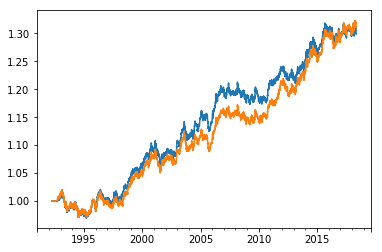

In [10]:
GRP_bt_test.cs_vol_control_backtest(CSRV)

(1. + GRP_bt_test.CSStrategy).cumprod().plot()
(1. + GRP_bt_test.CSStrategylag).cumprod().plot()

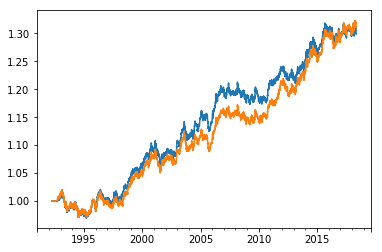

In [11]:
GRP_bt_test.cs_vol_control_backtest(CSRV)

(1. + GRP_bt_test.CSStrategy).cumprod().plot()
(1. + GRP_bt_test.CSStrategylag).cumprod().plot()

In [41]:
strat_name = 'IPM'

In [42]:
TS_dict[strat_name] = GRP_bt_test.TSStrategy
TS_dict_lag[strat_name] = GRP_bt_test.TSStrategylag
CS_dict[strat_name] = GRP_bt_test.CSStrategy
CS_dict_lag[strat_name] = GRP_bt_test.CSStrategylag

In [46]:
TS_dict_df = pd.DataFrame(TS_dict)
CS_dict_df = pd.DataFrame(CS_dict)

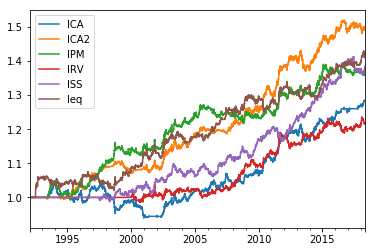

In [47]:
(1. + TS_dict_df.fillna(0)).cumprod().plot()

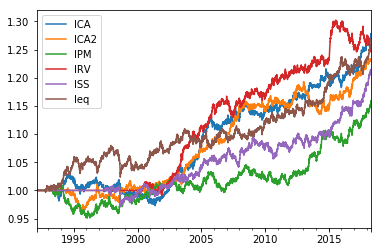

In [48]:
(1. + CS_dict_df.fillna(0)).cumprod().plot()

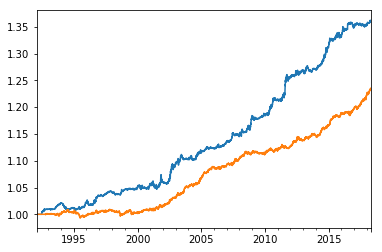

In [51]:
(1. + TS_dict_df.fillna(0).mean(axis=1)).cumprod().plot()
(1. + CS_dict_df.fillna(0).mean(axis=1)).cumprod().plot()

In [56]:
TS_dict_df.fillna(0).std() * np.sqrt(260)

ICA     0.019451
ICA2    0.018783
IPM     0.019949
IRV     0.017414
ISS     0.018439
Ieq     0.021684
dtype: float64

In [55]:
CS_dict_df.fillna(0).std() * np.sqrt(260)

ICA     0.020155
ICA2    0.019629
IPM     0.020044
IRV     0.017262
ISS     0.018493
Ieq     0.020446
dtype: float64

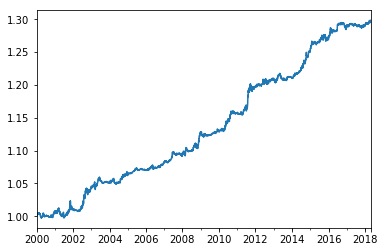

In [67]:
(1.+TS_dict_df.loc['2000':].mean(axis=1)).cumprod().plot()

In [68]:
(1.+TS_dict_df.loc['2000':].mean(axis=1)).cumprod().tail()

2018-05-03    1.298423
2018-05-04    1.298247
2018-05-07    1.298475
2018-05-08    1.298160
2018-05-09    1.298284
Freq: B, dtype: float64

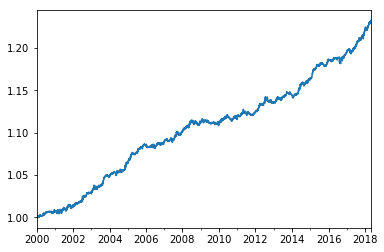

In [69]:
(1.+CS_dict_df.loc['2000':].mean(axis=1)).cumprod().plot()

In [70]:
(1.+CS_dict_df.loc['2000':].mean(axis=1)).cumprod().tail()

2018-05-03    1.232510
2018-05-04    1.232328
2018-05-07    1.232612
2018-05-08    1.232699
2018-05-09    1.232988
Freq: B, dtype: float64

In [63]:
TS_dict_df.loc['2000':].mean(axis=1).std() * np.sqrt(260)

0.011509770281469491

In [64]:
CS_dict_df.loc['2000':].mean(axis=1).std() * np.sqrt(260)

0.009136577023625473

## old ones,,

In [ ]:
def adjust_by_volband(df_vol, volband, weekday=1, min_vol=None):
    for i in range(1, len(df_vol.index)):
        if df_vol.iloc[i].name.weekday() == weekday:
            for c in range(len(df_vol.columns)):
                # case1. if new std is null
                if pd.isnull(df_vol.iloc[i, c]):
                    df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
                # case2. if new std within volband
                if abs(df_vol.iloc[i, c] - df_vol.iloc[i-1, c]) < volband * df_vol.iloc[i-1, c] :
                    df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
        else:
            df_vol.iloc[i] = df_vol.iloc[i-1]
    if min_vol is not None:
        df_vol[df_vol < min_vol] = min_vol

    return df_vol

In [33]:
# Param settings
CSLS = 'vol' # Cross Sectional Exposure Type. 'vol' means volatility allocation. 'notional' means notional. 

Assetvol = 0.02 # vol control parameter for individual assets
Strategyvol = 0.02 # vol control parameter for whole strategy
factorvol = 0.02
factorsd = 260 # lookback period for calcualting factorvol
assetsd = 90 # lookback period for calculating Assetvol
statsd = 90 # lookback period for calcualting Strategyvol

volband = 0.05 # if controled vol is within volband, do not change vol
min_vol = 0.15 # vol floor

In [34]:
# Calculating volatility for assets
std = (RET.rolling(window=assetsd).std() * np.sqrt(260)).iloc[assetsd:]

# Adjust calculated asset volatility
std_adj = adjust_by_volband(std.copy(), volband, min_vol=min_vol)

## Time Series

In [36]:
# Time Series 
VCweight = Assetvol / std_adj
VCTSpos = VCweight * TSRV # Vol Control Time Series Position
VCTSpos.replace([np.inf, -np.inf], np.nan, inplace=True)

# Strategy level vol control
# return of VC strategy
Strategy = (RET * VCTSpos.shift(1)).sum(axis=1)
# using average of expanding & moving window strategy risk
Strategyrisk_expanding = (Strategy.expanding(min_periods=statsd).std()*np.sqrt(260)).iloc[statsd:]
Strategyrisk_rolling = (Strategy.rolling(window=statsd).std()*np.sqrt(260)).iloc[statsd:]
Strategyrisk = (Strategyrisk_expanding + Strategyrisk_rolling) / 2.
# volband adjustment
bufrisk = adjust_by_volband(Strategyrisk.copy().to_frame(), volband)
# apply strategy level vol control to position
statlev = Strategyvol / bufrisk.iloc[:,0]
TSposition = VCTSpos.multiply(statlev, axis='index').iloc[statsd:]
TSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
TSposition.fillna(0, inplace=True)

In [37]:
# calculate daily strategy return
TSStrategy = (RET * TSposition.shift(1)).sum(axis=1)
TSStrategylag = (RET * TSposition.shift(2)).sum(axis=1)

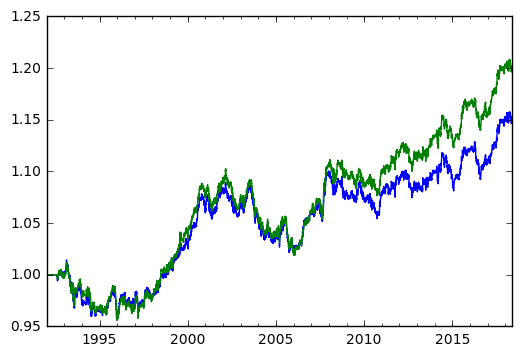

In [38]:
(1. + TSStrategy).cumprod().plot()
(1. + TSStrategylag).cumprod().plot()

## Cross Sectional

In [13]:
if CSLS == 'vol':
    CSRV = CSRV * Assetvol / std_adj

In [14]:
# Calculating Ex-ante Vol and adjust to target vol which specified by 'Strategyvol'
for i in range(len(CSRV.index)):
    if CSRV.iloc[i].name.weekday() == RB:
        CSRV.iloc[i] = CSRV.iloc[i] * Strategyvol / ex_ante_vol(RET, CSRV.iloc[i].name, CSRV.iloc[i])
    else:
        CSRV.iloc[i] = CSRV.iloc[i-1]

In [15]:
CSraw = (RET * CSRV.shift(1)).sum(axis=1)
CSrisk = (CSraw.rolling(window=statsd).std()*np.sqrt(260)).iloc[statsd:]

In [16]:
# volband adjustment
cs_bufrisk = adjust_by_volband(CSrisk.copy().to_frame(), volband)
# apply strategy level vol control to position
cs_statlev = Strategyvol / cs_bufrisk.iloc[:,0]
CSposition = CSRV.multiply(cs_statlev, axis='index').iloc[statsd:]
CSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
CSposition.fillna(0, inplace=True)

In [17]:
# calculate daily strategy return
CSStrategy = (RET * CSposition.shift(1)).sum(axis=1)
CSStrategylag = (RET * CSposition.shift(2)).sum(axis=1)

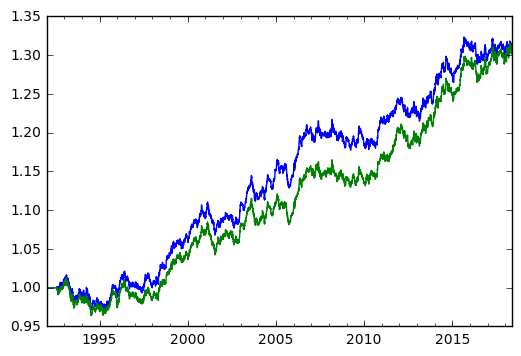

In [19]:
(1. + CSStrategy).cumprod().plot()
(1. + CSStrategylag).cumprod().plot()